## Access Vessel Air Sea Flux Product Delayed data in Parquet
A jupyter notebook to show how to access and plot the AODN vessel_air_sea_flux_product_delayed dataset available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/07818819-2e5c-4a12-9395-0082b57b2fe8).

In [1]:
dataset_name = "vessel_air_sea_flux_product_delayed"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    import xarray as xr
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 38ms


In [3]:
import requests
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

platform_code: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'platform_code')
print(list(unique_partition_value))  # showing a subset only

['VLMJ', 'VMIC', 'VNAA', 'VLHJ', 'ZMFR']
CPU times: user 40.8 ms, sys: 1.92 ms, total: 42.7 ms
Wall time: 42.5 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


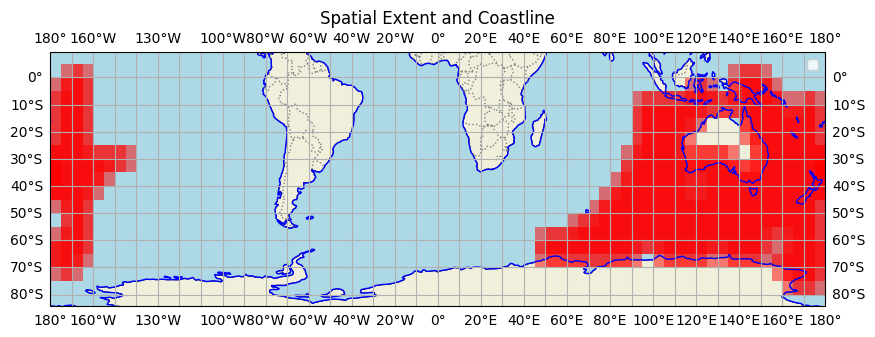

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [9]:
get_temporal_extent(parquet_ds)

(Timestamp('2008-04-16 02:49:59.999995648'),
 Timestamp('2025-02-25 21:46:59.999992832'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'platform_code': {'type': 'string'},
 'site': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts \nof the day'},
 'LATITUDE': {'type': 'float',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84'},
 'LONGITUDE': {'type': 'float',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180,
  'valid_max': 180,
  'reference_datum': 'geographical coordinates, WGS84'},
 'PL_CMP': {'type': 'float',
  'long_name': 'compass direction',
  'units': 'degrees_north',
  'instrument': 'Sperry gyro compasse Mk 37',
  'observation_t

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2022-12-01', date_end='2024-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-60, lat_max=-28, lon_min=140, lon_max=160)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191160 entries, 0 to 191159
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   filename          191160 non-null  object        
 1   site              191160 non-null  object        
 2   TIME              191160 non-null  datetime64[ns]
 3   LATITUDE          191160 non-null  float32       
 4   LONGITUDE         191160 non-null  float32       
 5   PL_CMP            191160 non-null  float32       
 6   PL_CRS            191160 non-null  float32       
 7   PL_SPD            191160 non-null  float32       
 8   WDIR              191160 non-null  float32       
 9   WSPD              191160 non-null  float32       
 10  WIND_H            191160 non-null  float32       
 11  WIND_FLAG         191160 non-null  int32         
 12  ATMP              191160 non-null  float32       
 13  ATMP_H            191160 non-null  float32       
 14  ATMP

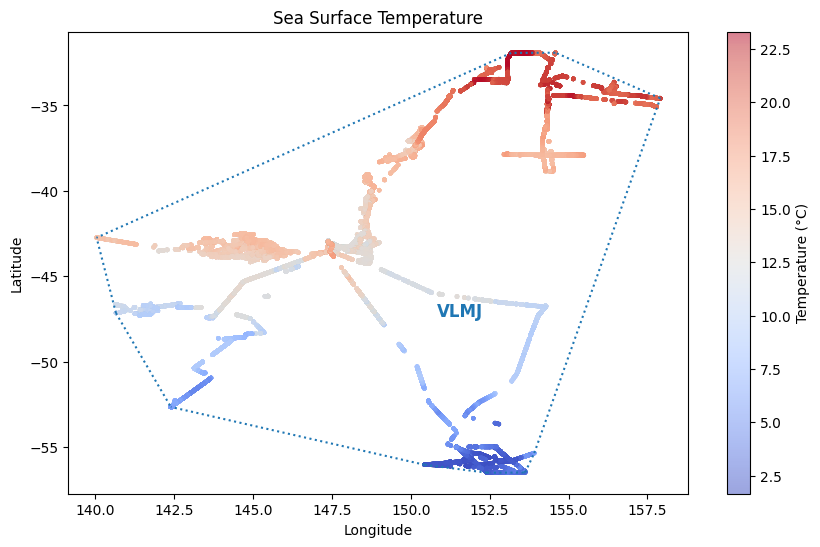

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from itertools import cycle

# function to plot the convex hull around the vessel's data points
def draw_convex_hull(ax, points, label, color):
    hull = ConvexHull(points)
    # Plot the convex hull as a dotted polygon
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], linestyle=':', color=color, linewidth=1.5)
    
    centroid = np.mean(points[hull.vertices], axis=0)
    ax.text(centroid[0], centroid[1], label, fontsize=12, weight='bold', ha='center', color=color)

plt.figure(figsize=(10, 6))

# Adjusting alpha to reduce darkness
sc = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['TEMP'], cmap='coolwarm', s=10, edgecolor='none', alpha=0.5)

cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Labels and titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')

# assign different colors to each platform
color_cycle = cycle(plt.cm.tab10.colors)  # Use a colormap with 10 distinct colors

# Group the data by platform_code
unique_vessels = df['platform_code'].unique()

# Draw convex hulls for each unique vessel
for vessel in unique_vessels:
    df_vessel = df[df['platform_code'] == vessel]
    
    # Combine the longitude and latitude into a set of points
    points = df_vessel[['LONGITUDE', 'LATITUDE']].to_numpy()
    
    # Only draw convex hull if there are enough points
    if len(points) >= 3:
        color = next(color_cycle)  # Get the next color from the color cycle
        draw_convex_hull(plt.gca(), points, vessel, color)

plt.show()


## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2025-01-01', date_end='2025-02-05')

#expr_1 = pc.field('platform_code') == 'VLMJ'
#filter = expr_1 & filter_time
filter =  filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124665 entries, 0 to 124664
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   filename          124665 non-null  object        
 1   site              124665 non-null  object        
 2   TIME              124665 non-null  datetime64[ns]
 3   LATITUDE          124665 non-null  float32       
 4   LONGITUDE         124665 non-null  float32       
 5   PL_CMP            124665 non-null  float32       
 6   PL_CRS            124665 non-null  float32       
 7   PL_SPD            124665 non-null  float32       
 8   WDIR              124665 non-null  float32       
 9   WSPD              124665 non-null  float32       
 10  WIND_H            124665 non-null  float32       
 11  WIND_FLAG         124665 non-null  int32         
 12  ATMP              124665 non-null  float32       
 13  ATMP_H            124665 non-null  float32       
 14  ATMP

In [16]:
df.TIME.max()

Timestamp('2025-02-04 23:42:59.999980544')

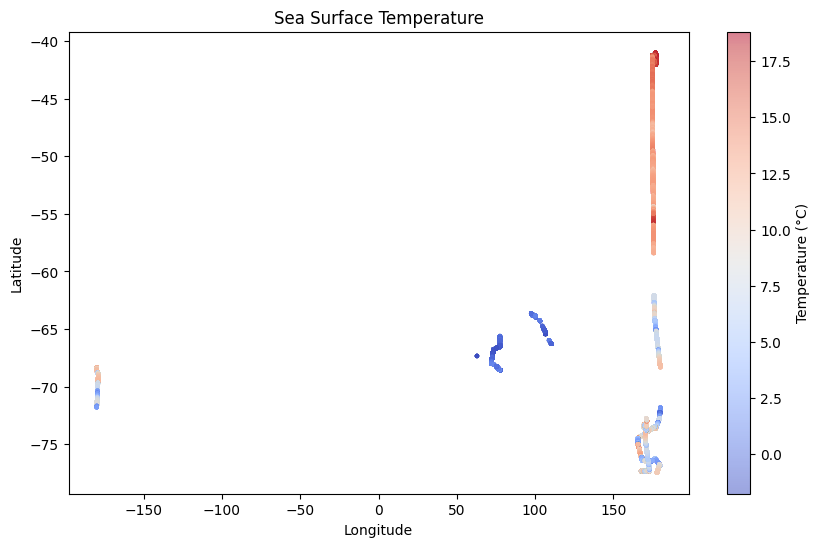

In [17]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['TEMP'], cmap='coolwarm', s=10, edgecolor='none', alpha=0.5)

# Adding colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Labels and titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')

plt.show()